# Add needed libraries

In [717]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as math

from sklearn.preprocessing import Imputer

# Read and combine data

## read data

The data is read into dataframes from the CSV's and the client ID is used as the index for the dataframe. The dimensions of each dataset is printed to see the similarities in the dataset.

In [718]:
#read CSVs
user_soc = pd.read_csv("Task_Data_Scientist_Dataset.xlsx - Soc_Dem.csv", sep=",", index_col="Client")
user_balance = pd.read_csv("Task_Data_Scientist_Dataset.xlsx - Products_ActBalance.csv", sep=",", index_col="Client")
user_flow = pd.read_csv("Task_Data_Scientist_Dataset.xlsx - Inflow_Outflow.csv", sep=",", index_col="Client")
user_sales = pd.read_csv("Task_Data_Scientist_Dataset.xlsx - Sales_Revenues.csv", sep=",", index_col="Client")

print(user_soc.shape)
print(user_balance.shape)
print(user_flow.shape)
print(user_sales.shape)




(1615, 3)
(1615, 12)
(1587, 14)
(969, 6)


As expected the sales dataset has less rows as this needs to be predicted for the rest of the clients.
Another thing that is noticed is that the inflow-outflow dataset has less clients in the list. 
The missing clients will be filtered out when combining the datasets.

## One hot encoding

When  looking at the data (in Excel) all variables where numeric expect for the Sex parameter. As machine learning algorithms don't work with categorical data, the Sex parameter is hot encoded into a numeric paremeter

In [719]:
#one hot encoding of sex
sex = user_soc['Sex']
sex_col = pd.get_dummies(sex, drop_first=True)
user_soc=user_soc.join(sex_col, how='outer')
user_soc_hot = user_soc.drop('Sex', axis=1)

In [720]:
user_soc_hot.head()

,Age,Tenure,M
Client,,,
909,21,27,1.0
1217,38,165,1.0
850,49,44,0.0
1473,54,34,1.0
1038,29,106,1.0


## Combine data

In [721]:
user = user_soc_hot.join(user_balance, how='inner')
user = user.join(user_flow, how='inner')
user = user.join(user_sales, how='left')

print(user.shape)

user.head()


(1587, 35)


,Age,Tenure,M,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1017,57,145,1.0,1,NaN,NaN,NaN,NaN,NaN,903.638214,...,12,2,9,0,0.0,0.0,0.0,0.0,0.000000,0.0
1456,61,149,0.0,1,1.0,NaN,NaN,NaN,NaN,0.000000,...,28,1,20,5,0.0,1.0,0.0,0.0,3.607143,0.0
545,20,151,1.0,1,1.0,NaN,NaN,NaN,NaN,3852.053929,...,23,3,5,12,NaN,NaN,NaN,NaN,NaN,NaN
667,48,143,1.0,1,NaN,NaN,NaN,NaN,NaN,60.044286,...,21,3,4,8,NaN,NaN,NaN,NaN,NaN,NaN
1381,38,135,1.0,1,NaN,NaN,NaN,NaN,NaN,144.871429,...,6,1,5,0,0.0,0.0,0.0,0.0,0.000000,0.0


Inner join is used for combining the Soc_Dem, Products_ActBalance and Inflow_Outflow dataset to only keep the clients with data is all datasets.
It is noticed all clients in the inflow-outflow dataset can also be found in the Soc_Dem and Products_ActBalance dataset 
For the sales data a left join is used as we know only part of the clients have this data filled in.

## Columns

In [722]:
print(user.columns.values)


['Age' 'Tenure' 'M' 'Count_CA' 'Count_SA' 'Count_MF' 'Count_OVD' 'Count_CC'
 'Count_CL' 'ActBal_CA' 'ActBal_SA' 'ActBal_MF' 'ActBal_OVD' 'ActBal_CC'
 'ActBal_CL' 'VolumeCred' 'VolumeCred_CA' 'TransactionsCred'
 'TransactionsCred_CA' 'VolumeDeb' 'VolumeDeb_CA' 'VolumeDebCash_Card'
 'VolumeDebCashless_Card' 'VolumeDeb_PaymentOrder' 'TransactionsDeb'
 'TransactionsDeb_CA' 'TransactionsDebCash_Card'
 'TransactionsDebCashless_Card' 'TransactionsDeb_PaymentOrder' 'Sale_MF'
 'Sale_CC' 'Sale_CL' 'Revenue_MF' 'Revenue_CC' 'Revenue_CL']


## missing values

In [723]:
#missing data
total = user.isnull().sum().sort_values(ascending=False)
percent = (user.isnull().sum()/user.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(35)

,Total,Percent
ActBal_CL,1452,0.914934
Count_CL,1452,0.914934
ActBal_CC,1417,0.892880
Count_CC,1417,0.892880
ActBal_MF,1282,0.807813
Count_MF,1282,0.807813
Count_OVD,1168,0.735980
ActBal_OVD,1168,0.735980
Count_SA,1161,0.731569
ActBal_SA,1161,0.731569


The setting of the missing values is done seperatly for each parameter.
But in the end it was clear no real parameters were missing but values were not filled in for accounts 
which the user did not have. So these values were filled in with 0.

# Exploratory analysis of the parameters

As the number of parameters are not too much a basic analysis of eahc parameter is done.
For each parameter the basic statistical data and the distribution in a histogram is shown.
Also the missing values are filled in for each parameter.
The outliers are manually checked and removed if needed

## Age

In [724]:
user['Age'].describe()


count    1587.000000
mean       42.770636
std        18.595829
min         0.000000
25%        29.000000
50%        41.000000
75%        57.000000
max        97.000000
Name: Age, dtype: float64

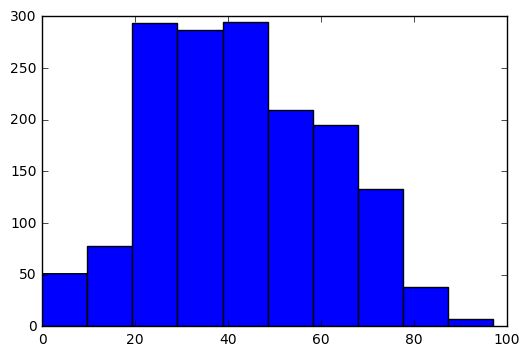

In [725]:
plt.hist(user['Age'])
plt.show()

It was noticed the minimum age of a client is 0. Which is possible but still odd. So this triggered some further analysis where the age was compared with the tenure of the client.

In [726]:
#Check which clients have more tenure than his age
#This is probably a faulty age
user.loc[user['Tenure']/12 > user['Age']]



,Age,Tenure,M,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
391,1,16,1.0,1,NaN,NaN,NaN,1.0,1.0,172.581429,...,18,4,0,6,0.0,0.0,0.0,0.000000,0.000000,0.000000
1056,10,159,0.0,1,NaN,NaN,NaN,NaN,NaN,283.605000,...,1,0,0,0,1.0,0.0,1.0,10.527143,0.000000,12.000000
350,4,218,0.0,1,NaN,NaN,1.0,NaN,NaN,0.000000,...,20,4,0,7,NaN,NaN,NaN,NaN,NaN,NaN
682,3,149,0.0,1,1.0,11.0,NaN,NaN,NaN,684.281429,...,22,12,0,2,0.0,1.0,1.0,0.000000,0.214286,9.392857
1169,6,172,0.0,1,NaN,NaN,NaN,NaN,NaN,1824.040000,...,9,1,7,0,1.0,1.0,1.0,2.461964,5.170357,46.392857
1499,5,267,0.0,1,NaN,NaN,1.0,NaN,1.0,0.000000,...,30,4,10,12,0.0,0.0,1.0,0.000000,0.000000,7.107143
1160,19,260,1.0,1,NaN,NaN,1.0,NaN,1.0,2723.980357,...,26,3,9,7,0.0,1.0,1.0,0.000000,0.857143,17.993214
1583,8,151,1.0,1,NaN,NaN,NaN,NaN,NaN,4038.971071,...,10,3,1,4,0.0,0.0,1.0,0.000000,0.000000,30.250000
1427,4,179,0.0,1,1.0,NaN,NaN,NaN,NaN,6.552143,...,1,0,0,0,0.0,0.0,1.0,0.000000,0.000000,10.357143


47 Clients were found with a tenure that was longer than the age of the client. So one of these 2 parameters is wrong. As The tenure is probably calculated a more correct way I assume the age is the faulty parameter.
Lets see what we can do.

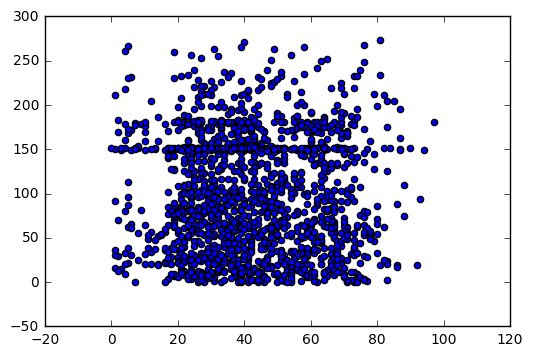

In [727]:
#Check if there is a correlation between tenure and age to maybe use the tenure to set the age
plt.scatter(user['Age'], user['Tenure'])
plt.show()

First I checked if the value could be imputed from the tenure. But no correlation was found for this data.
Then I also tried just dropping these clients as it only consisted of 47 clients but this had a noticable impact 
on the models. So finally it was decided to just replace these ages with the mean of the age parameter which is 42.

In [728]:
#Drop the clients with tenure bigger than the age
user['Age'].loc[user['Tenure']/12 > user['Age']] = user['Age'].mean()

/home/nico/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Tenure

In [729]:
user['Tenure'].describe()

count    1587.000000
mean      101.242596
std        65.059802
min         0.000000
25%        44.000000
50%        96.000000
75%       151.000000
max       273.000000
Name: Tenure, dtype: float64

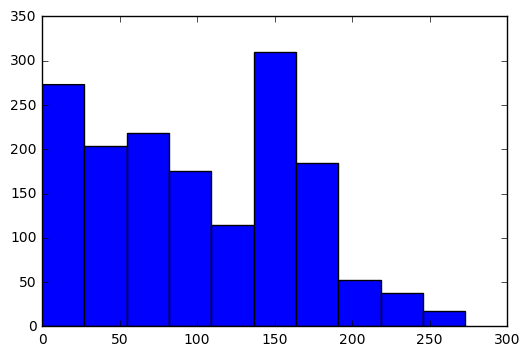

In [730]:
plt.hist(user['Tenure'])
plt.show()

## Count_CA

In [731]:
user['Count_CA'].describe()

count    1587.000000
mean        1.078135
std         0.331521
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: Count_CA, dtype: float64

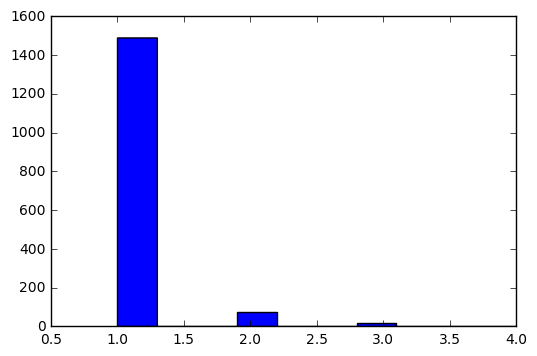

In [732]:
plt.hist(user['Count_CA'])
plt.show()

## Count_SA

In [733]:
user['Count_SA'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    426.000000
mean       1.166667
std        0.468205
min        1.000000
25%             NaN
50%             NaN
75%             NaN
max        5.000000
Name: Count_SA, dtype: float64

In [734]:
#Set 0 for clients with no saving accounts
user['Count_SA'].fillna(0,inplace=True)

In [735]:
user['Count_SA'].describe()

count    1587.00000
mean        0.31317
std         0.57114
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         5.00000
Name: Count_SA, dtype: float64

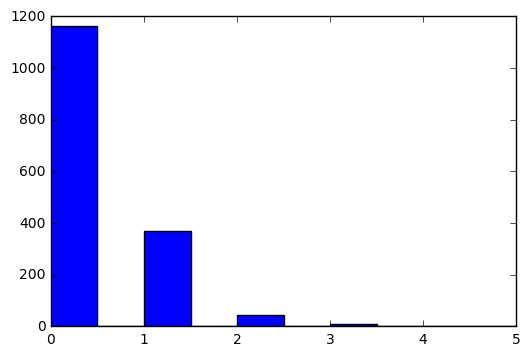

In [736]:
plt.hist(user['Count_SA'])
plt.show()

## Count_MF

In [737]:
user['Count_MF'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    305.000000
mean       4.672131
std        7.857533
min        1.000000
25%             NaN
50%             NaN
75%             NaN
max       79.000000
Name: Count_MF, dtype: float64

In [738]:
#Set 0 for clients with no mutual funds
user['Count_MF'].fillna(0,inplace=True)

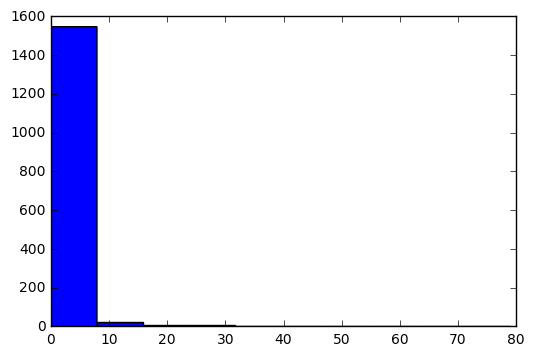

In [739]:
plt.hist(user['Count_MF'])
plt.show()

## Count_OVD

In [740]:
user['Count_OVD'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    419.0
mean       1.0
std        0.0
min        1.0
25%        NaN
50%        NaN
75%        NaN
max        1.0
Name: Count_OVD, dtype: float64

In [741]:
user['Count_OVD'].fillna(0,inplace=True)

In [742]:
user['Count_OVD'].describe()

count    1587.000000
mean        0.264020
std         0.440949
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Count_OVD, dtype: float64

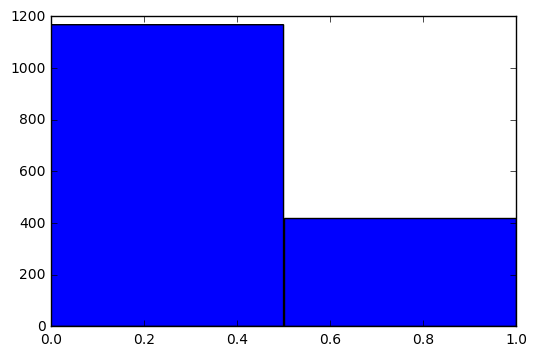

In [743]:
plt.hist(user['Count_OVD'], bins=2)
plt.show()

## Count_CC

In [744]:
user['Count_CC'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    170.0
mean       1.0
std        0.0
min        1.0
25%        NaN
50%        NaN
75%        NaN
max        1.0
Name: Count_CC, dtype: float64

In [745]:
user['Count_CC'].fillna(0,inplace=True)

In [746]:
user['Count_CC'].describe()

count    1587.000000
mean        0.107120
std         0.309364
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Count_CC, dtype: float64

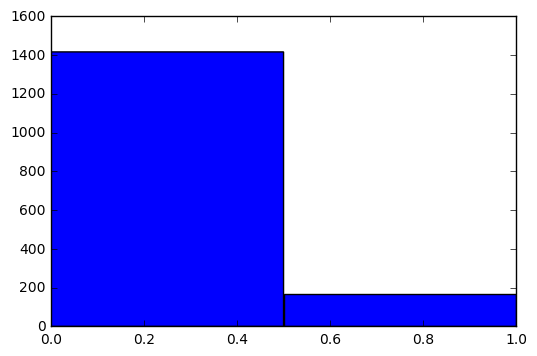

In [747]:
plt.hist(user['Count_CC'], bins=2)
plt.show()

## Count_CL

In [748]:
user['Count_CL'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count    135.000000
mean       1.185185
std        0.520980
min        1.000000
25%             NaN
50%             NaN
75%             NaN
max        5.000000
Name: Count_CL, dtype: float64

In [749]:
#remove outliers
user = user.loc[user['Count_CL'] != 5]

In [750]:
user['Count_CL'].fillna(0,inplace=True)

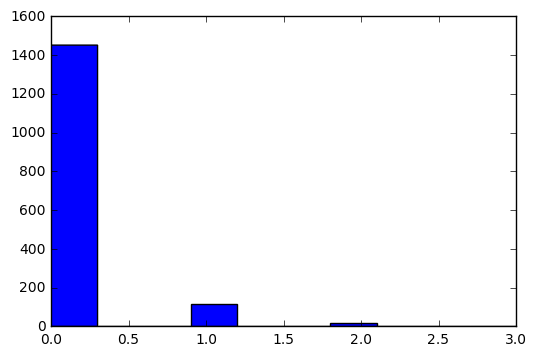

In [751]:
plt.hist(user['Count_CL'])
plt.show()

## ActBal_CA

In [752]:
user['ActBal_CA'].describe()

count      1586.000000
mean       2454.532665
std        7112.686401
min           0.000000
25%          61.942679
50%         465.076964
75%        2179.794107
max      171575.889600
Name: ActBal_CA, dtype: float64

In [753]:
user['ActBal_CA'].sort_values(ascending = False).head()

Client
1414    171575.88960
230      74934.95607
210      60226.14179
1000     55934.02036
1406     55383.79786
Name: ActBal_CA, dtype: float64

In [754]:
#remove outliers
user = user.loc[user['ActBal_CA']<171575]

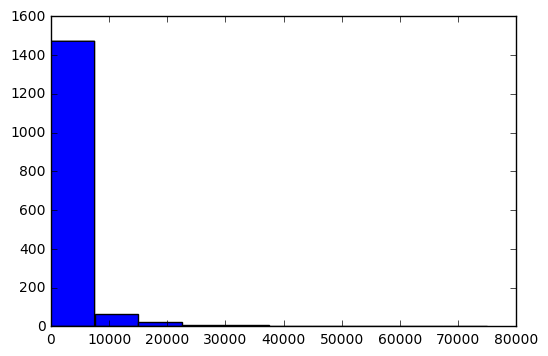

In [755]:
plt.hist(user['ActBal_CA'])
plt.show()

In [756]:
#Add column based on average per account
user = user.assign(Actbal_CA_avg = lambda x:x.ActBal_CA/x.Count_CA)



## ActBal_SA

In [757]:
user['ActBal_SA'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count       425.000000
mean      15220.090524
std       32401.055154
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max      389883.830700
Name: ActBal_SA, dtype: float64

In [758]:
user['ActBal_SA'].sort_values(ascending = False).head()

Client
219    389883.8307
352    219368.6464
197    191591.1896
21     173499.8629
322    128617.5911
Name: ActBal_SA, dtype: float64

In [759]:
user['ActBal_SA'].fillna(0,inplace=True)

In [760]:
#remove outliers
user = user.loc[user['ActBal_SA']<389883]

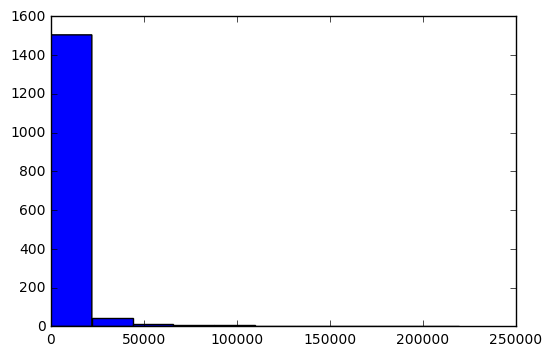

In [761]:
plt.hist(user['ActBal_SA'])
plt.show()

In [762]:
#Add column based on average per account
user = user.assign(ActBal_SA_avg = lambda x:x.ActBal_SA/x.Count_SA)
user['ActBal_SA_avg'].fillna(0,inplace=True)

## ActBal_MF

In [763]:
user['ActBal_MF'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count       304.000000
mean      20596.959524
std       78296.103759
min           0.000000
25%                NaN
50%                NaN
75%                NaN
max      761235.504300
Name: ActBal_MF, dtype: float64

In [764]:
user['ActBal_MF'].sort_values(ascending = False).head(10)

Client
678     761235.50430
314     714285.71430
775     579084.10790
543     446183.42320
1118    314723.16500
239     227237.10430
324     202941.60890
643     181931.54710
1041    178571.42860
1329     90062.94607
Name: ActBal_MF, dtype: float64

In [765]:
user['ActBal_MF'].fillna(0,inplace=True)

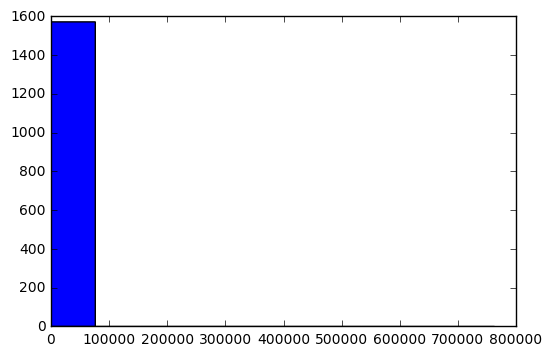

In [766]:
plt.hist(user['ActBal_MF'])
plt.show()

In [767]:
#Add column based on average per account
user = user.assign(ActBal_MF_avg = lambda x:x.ActBal_MF/x.Count_MF)
user['ActBal_MF_avg'].fillna(0,inplace=True)

## ActBal_OVD

In [768]:
user['ActBal_OVD'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count     419.000000
mean      126.449897
std       290.573266
min         0.000000
25%              NaN
50%              NaN
75%              NaN
max      2055.325357
Name: ActBal_OVD, dtype: float64

In [769]:
user['ActBal_OVD'].sort_values(ascending = False).head(10)

Client
1117    2055.325357
1130    1776.065357
1464    1670.280714
1467    1568.879643
747     1459.457143
41      1373.342857
1263    1211.621071
1519    1076.430357
1576    1031.077143
1378    1019.002500
Name: ActBal_OVD, dtype: float64

In [770]:
user['ActBal_OVD'].fillna(0,inplace=True)

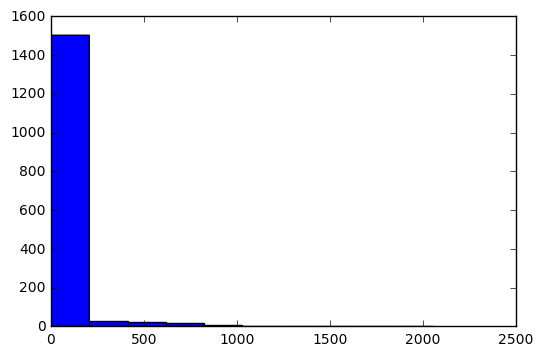

In [771]:
plt.hist(user['ActBal_OVD'])
plt.show()

In [772]:
#Add column based on average per account
user = user.assign(ActBal_OVD_avg = lambda x:x.ActBal_OVD/x.Count_OVD)
user['ActBal_OVD_avg'].fillna(0,inplace=True)

## ActBal_CC

In [773]:
user['ActBal_CC'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count     169.000000
mean      353.360218
std       487.378762
min       -15.479286
25%              NaN
50%              NaN
75%              NaN
max      3522.233571
Name: ActBal_CC, dtype: float64

In [774]:
user['ActBal_CC'].sort_values(ascending = False).head(10)

Client
214     3522.233571
1098    2382.946071
1429    1767.785357
763     1529.058929
1510    1400.918571
571     1223.214286
1494    1202.720357
916     1188.786786
4       1110.381786
796     1109.505714
Name: ActBal_CC, dtype: float64

In [775]:
user['ActBal_CC'].fillna(0,inplace=True)


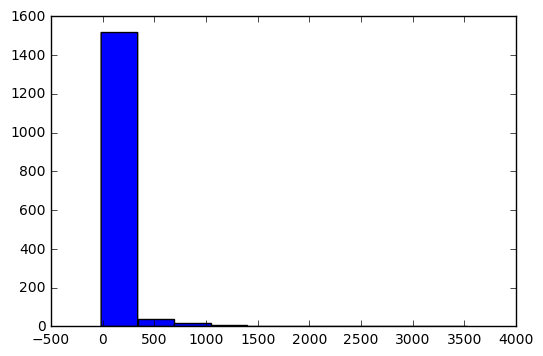

In [776]:
plt.hist(user['ActBal_CC'])
plt.show()

In [777]:
#Add column based on average per account
user = user.assign(ActBal_CC_avg = lambda x:x.ActBal_CC/x.Count_CC)
user['ActBal_CC_avg'].fillna(0,inplace=True)

## ActBal_CL

In [778]:
user['ActBal_CL'].describe()

/home/nico/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4116: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


count      134.000000
mean      4258.023627
std       4176.011324
min          0.000000
25%               NaN
50%               NaN
75%               NaN
max      20749.294640
Name: ActBal_CL, dtype: float64

In [779]:
user['ActBal_CL'].sort_values(ascending = False).head(10)

Client
175     20749.29464
113     17300.48964
14      17062.32429
32      14708.57143
342     14516.52429
174     14233.63607
948     13012.38571
1499    12738.25536
914     12567.02571
1387    11462.72036
Name: ActBal_CL, dtype: float64

In [780]:
user['ActBal_CL'].fillna(0,inplace=True)

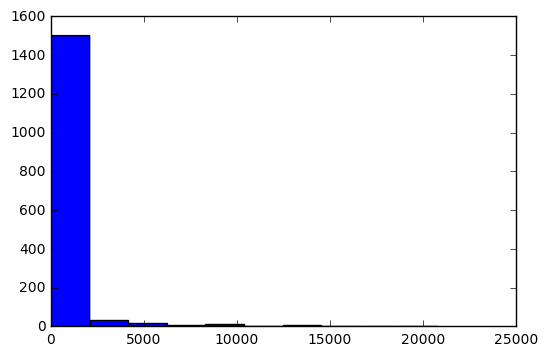

In [781]:
plt.hist(user['ActBal_CL'])
plt.show()

In [782]:
#Add column based on average per account
user = user.assign(ActBal_CL_avg = lambda x:x.ActBal_CL/x.Count_CL)
user['ActBal_CL_avg'].fillna(0,inplace=True)

## VolumeCred

In [783]:
user['VolumeCred'].describe()

count      1584.000000
mean       1803.287765
std        5817.013475
min           0.000000
25%         252.175357
50%         655.146429
75%        1418.570000
max      107703.804300
Name: VolumeCred, dtype: float64

In [784]:
user['VolumeCred'].sort_values(ascending = False).head(10)

Client
424     107703.80430
984      98717.67500
1077     90124.60964
924      68371.54214
506      46756.54071
302      43319.25464
1538     35830.19286
1373     33409.29357
110      32975.32607
327      29709.15321
Name: VolumeCred, dtype: float64

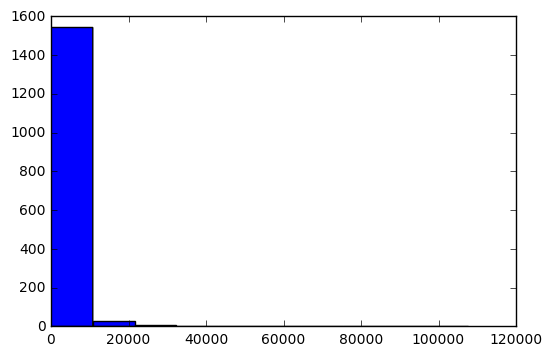

In [785]:
plt.hist(user['VolumeCred'])
plt.show()

## VolumeCred_CA

In [786]:
user['VolumeCred_CA'].describe()

count     1584.000000
mean      1502.907237
std       4662.823212
min          0.000000
25%        214.289464
50%        620.555357
75%       1301.173125
max      98717.675000
Name: VolumeCred_CA, dtype: float64

In [787]:
user['VolumeCred_CA'].sort_values(ascending = False).head(10)

Client
984     98717.67500
1077    68667.55250
924     66908.95107
424     54128.37929
506     46714.29214
1373    33409.29357
197     29178.26893
766     25314.01286
1584    23091.72786
302     21797.60929
Name: VolumeCred_CA, dtype: float64

In [788]:
#remove outliers
user = user.loc[user['VolumeCred_CA']<98717]

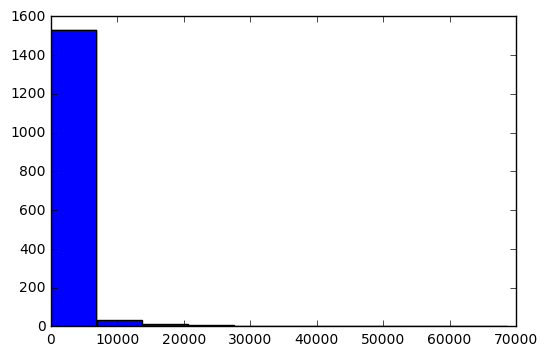

In [789]:
plt.hist(user['VolumeCred_CA'])
plt.show()

## TransactionsCred

In [790]:
user['TransactionsCred'].describe()

count    1583.000000
mean        5.536323
std         6.361013
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        63.000000
Name: TransactionsCred, dtype: float64

In [791]:
user['TransactionsCred'].sort_values(ascending = False).head(10)

Client
491     63
153     56
697     44
210     43
1151    42
1104    40
1220    39
775     39
102     38
756     37
Name: TransactionsCred, dtype: int64

In [792]:
#remove outliers
user = user.loc[user['TransactionsCred']<63]

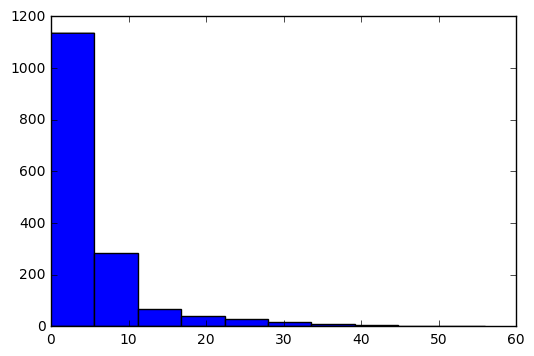

In [793]:
plt.hist(user['TransactionsCred'])
plt.show()

## TransactionsCred_CA

In [794]:
user['TransactionsCred_CA'].describe()

count    1582.000000
mean        4.234513
std         4.826005
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        37.000000
Name: TransactionsCred_CA, dtype: float64

In [795]:
user['TransactionsCred_CA'].sort_values(ascending = False).head(10)

Client
153     37
1373    36
1151    35
1220    33
102     33
697     33
1179    32
583     30
756     30
668     30
Name: TransactionsCred_CA, dtype: int64

In [796]:
#remove outliers
user = user.loc[user['TransactionsCred_CA']<48]

In [797]:
#user['TransactionsCred_CA']=np.sqrt(user['TransactionsCred_CA']+1)

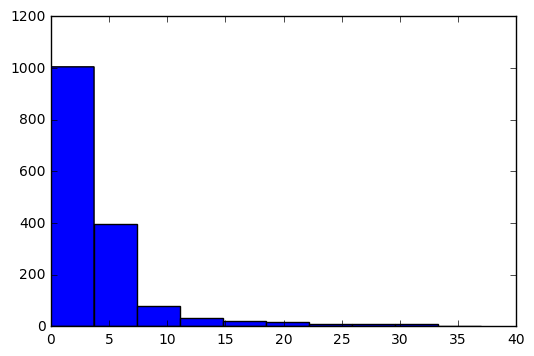

In [798]:
plt.hist(user['TransactionsCred_CA'])
plt.show()

## VolumeDeb

In [799]:
user['VolumeDeb'].describe()

count      1582.000000
mean       1642.850451
std        4983.535106
min           0.000000
25%         224.946607
50%         653.247857
75%        1410.717768
max      119906.503900
Name: VolumeDeb, dtype: float64

In [800]:
user['VolumeDeb'].sort_values(ascending = False).head(10)

Client
1077    119906.50390
924      64608.36143
424      59500.93250
1373     44078.18393
1289     38436.78107
1538     35714.28571
873      35196.56643
197      30910.96429
327      30555.35750
1455     28189.35000
Name: VolumeDeb, dtype: float64

In [801]:
#remove outliers
user = user.loc[user['VolumeDeb']<119906]

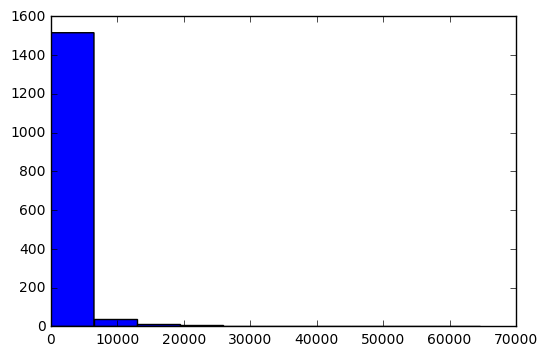

In [802]:
plt.hist(user['VolumeDeb'])
plt.show()

## VolumeDeb_CA

In [803]:
user['VolumeDeb_CA'].describe()

count     1581.000000
mean      1360.785063
std       3601.428241
min          0.000000
25%        211.320714
50%        627.239286
75%       1317.101429
max      64178.185360
Name: VolumeDeb_CA, dtype: float64

In [804]:
user['VolumeDeb_CA'].sort_values(ascending = False).head(10)

Client
924     64178.18536
424     59500.93250
1373    44078.18393
1538    35714.28571
873     35196.56643
197     30910.96429
1455    28189.35000
1584    27026.03571
1590    24382.80286
302     22936.42500
Name: VolumeDeb_CA, dtype: float64

In [805]:
#remove outliers
#user.drop(user[np.abs(user.VolumeDeb_CA-user.VolumeDeb_CA.mean())>(3*user.VolumeDeb_CA.std())].index.values, inplace = True)

In [806]:
#user['VolumeDeb_CA']=np.sqrt(user['VolumeDeb_CA']+1)

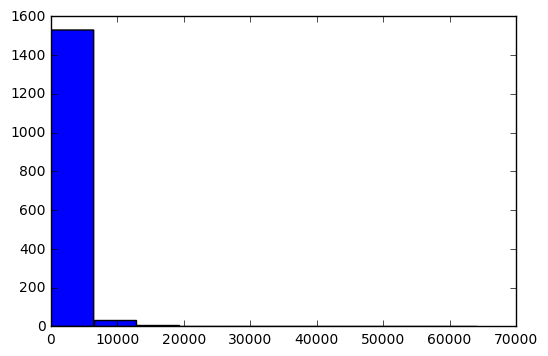

In [807]:
plt.hist(user['VolumeDeb_CA'])
plt.show()

## VolumeDebCash_Card

In [808]:
user['VolumeDebCash_Card'].describe()

count    1581.000000
mean      243.693041
std       481.699818
min         0.000000
25%         0.000000
50%        71.428571
75%       353.571429
max      9714.285714
Name: VolumeDebCash_Card, dtype: float64

In [809]:
user['VolumeDebCash_Card'].sort_values(ascending = False).head(10)

Client
243     9714.285714
642     6428.571429
496     4513.758929
734     3535.714286
327     3457.142857
1224    3271.428571
504     2892.857143
535     2857.142857
1590    2777.428571
1231    2250.000000
Name: VolumeDebCash_Card, dtype: float64

In [810]:
#remove outliers
user = user.loc[user['VolumeDeb']<23571]

In [811]:
#user['VolumeDebCash_Card']=np.sqrt(user['VolumeDebCash_Card']+1)

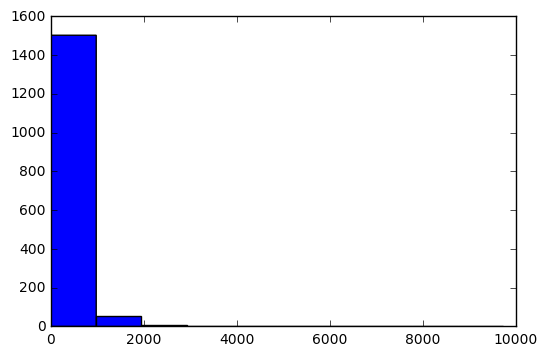

In [812]:
plt.hist(user['VolumeDebCash_Card'])
plt.show()

## VolumeDebCashless_Card

In [813]:
user['VolumeDebCashless_Card'].describe()

count    1570.000000
mean      146.581727
std       296.735220
min         0.000000
25%         0.000000
50%        19.141071
75%       174.450893
max      3637.616786
Name: VolumeDebCashless_Card, dtype: float64

In [814]:
user['VolumeDebCashless_Card'].sort_values(ascending = False).head(10)

Client
402     3637.616786
408     3335.426071
1224    3292.765000
200     2470.335714
504     2168.025000
736     1889.976429
210     1805.782500
823     1800.720357
676     1758.004643
1604    1645.366071
Name: VolumeDebCashless_Card, dtype: float64

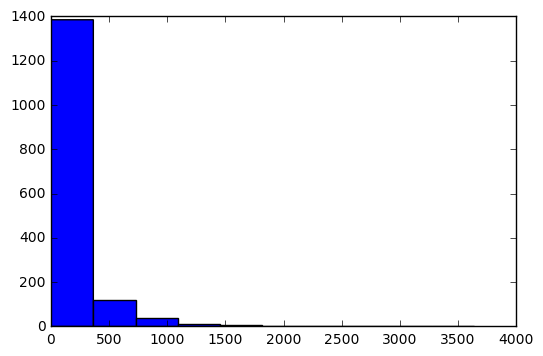

In [815]:
plt.hist(user['VolumeDebCashless_Card'])
plt.show()

## VolumeDeb_PaymentOrder

In [816]:
user['VolumeDeb_PaymentOrder'].describe()

count     1570.000000
mean       513.051541
std       1353.009361
min          0.000000
25%          0.000000
50%        172.232143
75%        487.198214
max      17946.428570
Name: VolumeDeb_PaymentOrder, dtype: float64

In [817]:
user['VolumeDeb_PaymentOrder'].sort_values(ascending = False).head(10)

Client
330     17946.42857
143     15311.78571
715     14294.66321
1510    13875.00000
1496    13419.37036
1293    13195.82143
408     12473.27607
347     12469.50000
217     11428.57143
874     11324.48393
Name: VolumeDeb_PaymentOrder, dtype: float64

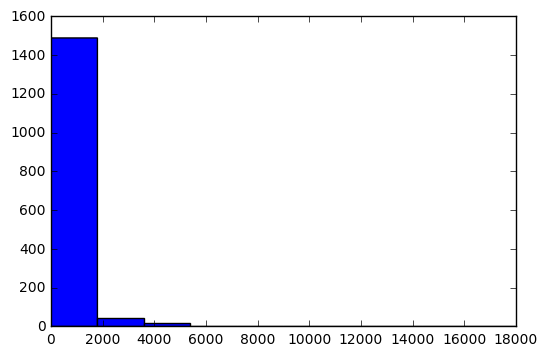

In [818]:
plt.hist(user['VolumeDeb_PaymentOrder'])
plt.show()

## TransactionsDeb

In [819]:
user['TransactionsDeb'].describe()

count    1570.000000
mean       15.764968
std        15.933983
min         0.000000
25%         4.000000
50%        11.000000
75%        22.000000
max       102.000000
Name: TransactionsDeb, dtype: float64

In [820]:
user['TransactionsDeb'].sort_values(ascending = False).head(10)

Client
1104    102
668      99
1042     96
697      95
153      92
1157     87
102      86
1230     86
756      86
1496     84
Name: TransactionsDeb, dtype: int64

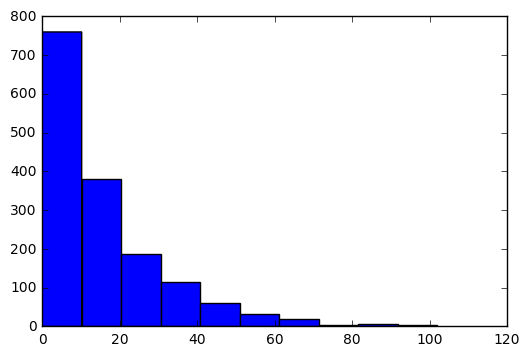

In [821]:
plt.hist(user['TransactionsDeb'])
plt.show()

## TransactionsDeb_CA

In [822]:
user['TransactionsDeb_CA'].describe()

count    1570.000000
mean       13.379618
std        12.667784
min         0.000000
25%         4.000000
50%        10.000000
75%        19.000000
max        79.000000
Name: TransactionsDeb_CA, dtype: float64

In [823]:
user['TransactionsDeb_CA'].sort_values(ascending = False).head(10)

Client
465     79
1177    75
1157    75
1042    74
668     72
866     70
353     69
1104    69
53      68
1480    65
Name: TransactionsDeb_CA, dtype: int64

In [824]:
#remove outliers
user = user.loc[user['TransactionsDeb_CA']<83]

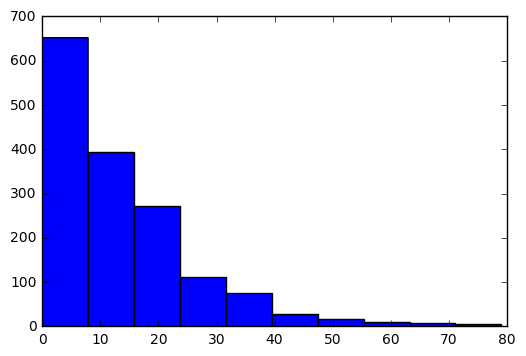

In [825]:
plt.hist(user['TransactionsDeb_CA'])
plt.show()

## TransactionsDebCash_Card

In [826]:
user['TransactionsDebCash_Card'].describe()

count    1570.000000
mean        1.987898
std         2.712806
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        25.000000
Name: TransactionsDebCash_Card, dtype: float64

In [827]:
user['TransactionsDebCash_Card'].sort_values(ascending = False).head(10)

Client
465     25
575     21
496     17
1157    16
705     16
1443    16
1365    15
68      13
401     13
996     13
Name: TransactionsDebCash_Card, dtype: int64

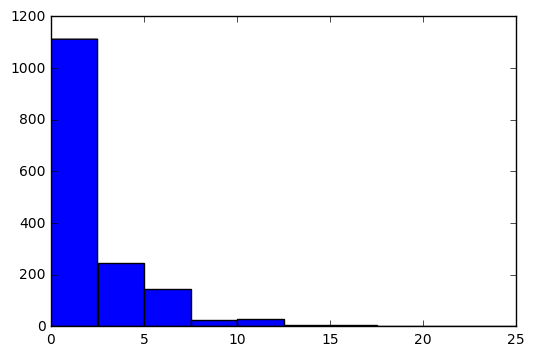

In [828]:
plt.hist(user['TransactionsDebCash_Card'])
plt.show()

## TransactionsDebCashless_Card

In [829]:
user['TransactionsDebCashless_Card'].describe()

count    1570.000000
mean        5.157325
std         8.241269
min         0.000000
25%         0.000000
50%         1.000000
75%         7.000000
max        60.000000
Name: TransactionsDebCashless_Card, dtype: float64

In [830]:
user['TransactionsDebCashless_Card'].sort_values(ascending = False).head(10)

Client
1496    60
150     48
1226    47
78      47
1480    46
823     44
64      42
1042    40
1393    39
200     39
Name: TransactionsDebCashless_Card, dtype: int64

In [831]:
#remove outliers
user = user.loc[user['TransactionsDebCashless_Card']<60]

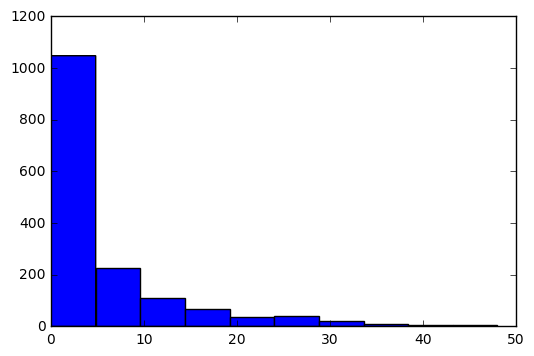

In [832]:
plt.hist(user['TransactionsDebCashless_Card'])
plt.show()

## TransactionsDeb_PaymentOrder

In [833]:
user['TransactionsDeb_PaymentOrder'].describe()

count    1569.000000
mean        4.492670
std         5.058974
min         0.000000
25%         0.000000
50%         3.000000
75%         7.000000
max        34.000000
Name: TransactionsDeb_PaymentOrder, dtype: float64

In [834]:
user['TransactionsDeb_PaymentOrder'].sort_values(ascending = False).head(10)

Client
53      34
408     31
697     31
353     26
413     25
666     25
614     24
321     24
1098    24
747     24
Name: TransactionsDeb_PaymentOrder, dtype: int64

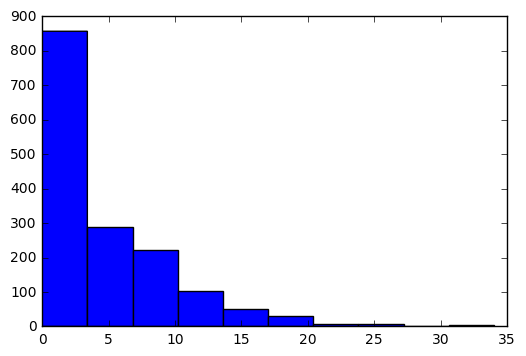

In [835]:
plt.hist(user['TransactionsDeb_PaymentOrder'])
plt.show()

# Check distrubution train parameter data

After analysis it is clear there is an imbalance in the classes. This is important for setting up the models.

In [836]:
user_train = user[pd.notnull(user['Sale_MF'])]

##  Sale_MF

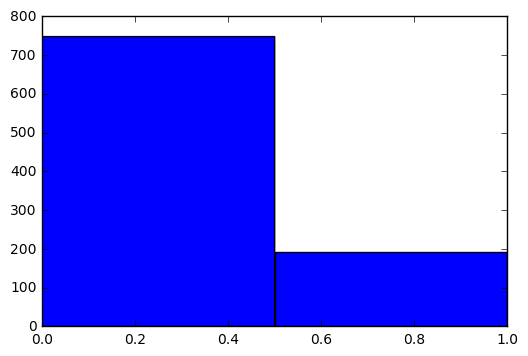

In [837]:
plt.hist(user_train['Sale_MF'], bins=2)
plt.show()

## Sale_CC

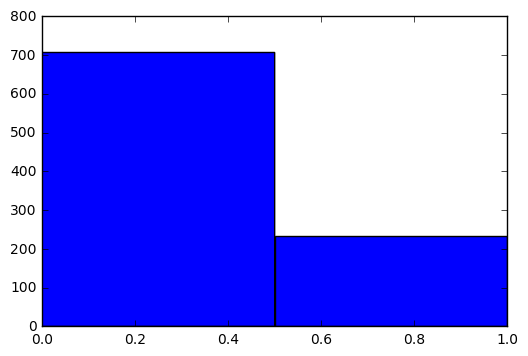

In [838]:
plt.hist(user_train['Sale_CC'], bins=2)
plt.show()

## Sale_CL

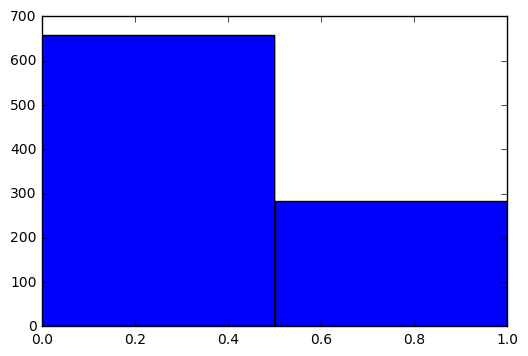

In [839]:
plt.hist(user_train['Sale_CL'], bins=2)
plt.show()

## Revenue_MF

In [840]:
user_train['Revenue_MF'].describe()

count    940.000000
mean       1.978265
std       10.089587
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      220.488214
Name: Revenue_MF, dtype: float64

In [860]:
user['Revenue_MF'].sort_values(ascending = False).head(10)

Client
614     83.038036
43      73.041786
349     65.704107
310     56.139821
437     54.330357
792     52.618214
801     51.965536
69      42.716607
700     40.677857
1537    38.431429
Name: Revenue_MF, dtype: float64

In [842]:
#remove outliers
user = user.loc[(user['Revenue_MF'].isnull()) | (user['Revenue_MF']<220)  ]

In [ ]:
plt.hist(user_train['Revenue_MF']!=0)
plt.show()

## Revenue_CC

In [844]:
user_train['Revenue_CC'].describe()

count    940.000000
mean       2.718633
std       17.937981
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      407.962500
Name: Revenue_CC, dtype: float64

In [858]:
user['Revenue_CC'].sort_values(ascending = False).head(10)

Client
448     213.292857
966     203.790714
617     110.470000
479     102.146429
1293     89.761071
374      76.859286
629      49.080714
475      42.688571
754      39.276786
388      37.233214
Name: Revenue_CC, dtype: float64

In [846]:
#remove outliers
user = user.loc[(user['Revenue_CC'].isnull()) | (user['Revenue_CC']<407) ]

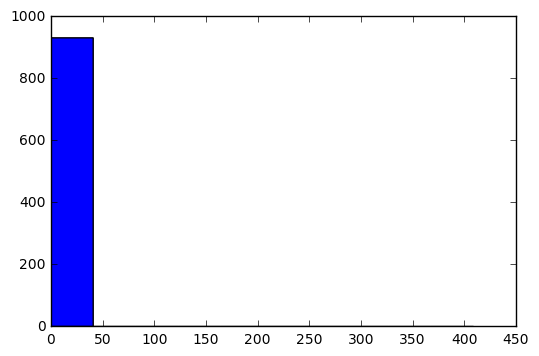

In [847]:
plt.hist(user_train['Revenue_CC'])
plt.show()

## Revenue_CL

In [848]:
user_train['Revenue_CL'].describe()

count    940.000000
mean       3.640608
std        7.810255
min        0.000000
25%        0.000000
50%        0.000000
75%        4.796964
max      133.275357
Name: Revenue_CL, dtype: float64

In [859]:
user['Revenue_CL'].sort_values(ascending = False).head(10)

Client
1169    46.392857
417     36.050714
236     32.132857
1524    31.801429
22      30.560357
1583    30.250000
553     29.781071
83      28.685357
729     28.148929
1083    27.551786
Name: Revenue_CL, dtype: float64

In [850]:
#remove outliers
user = user.loc[(user['Revenue_CL'].isnull()) | (user['Revenue_CL']<133) ]

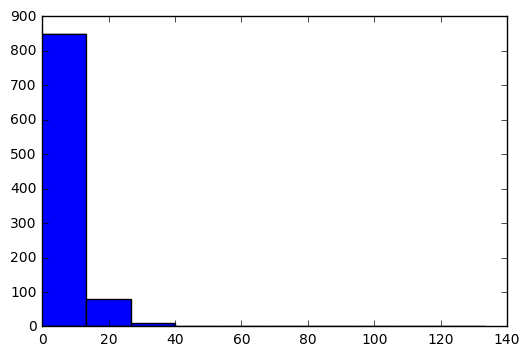

In [851]:
plt.hist(user_train['Revenue_CL'])
plt.show()

# Check correlation

Correlation between the different parameters is checked. This can be usefull for PCA for example to determine the needed number of parameters.

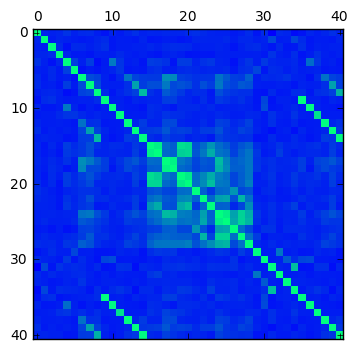

In [852]:
cov_data = user_train.corr()
plt.matshow(cov_data, cmap=plt.cm.winter)
plt.show()

In [853]:
counter =0
for index, row in cov_data.iterrows():
    for index,item in row.iteritems():
        if(item>0.7 or item<-0.7):
            counter = counter +1
            
print("number of correlation in the dataset = " + str(counter))

number of correlation in the dataset = 77


In [854]:
cov_data.shape

(41, 41)

In [855]:
print((counter-41)/2)

18.0


In [856]:
print(user.shape)

(1566, 41)


In [857]:
user.to_csv(path_or_buf='analysis_data.csv')